# Example: Training a GapNet

This tutorial gives an overview of how to use GapNet.

GapNet is an alternative deep-learning training approach that can use highly incomplete datasets. This is the code for the arXiv preprint 2107.00429 [Neural Network Training with Highly Incomplete Datasets](https://arxiv.org/abs/2107.00429).

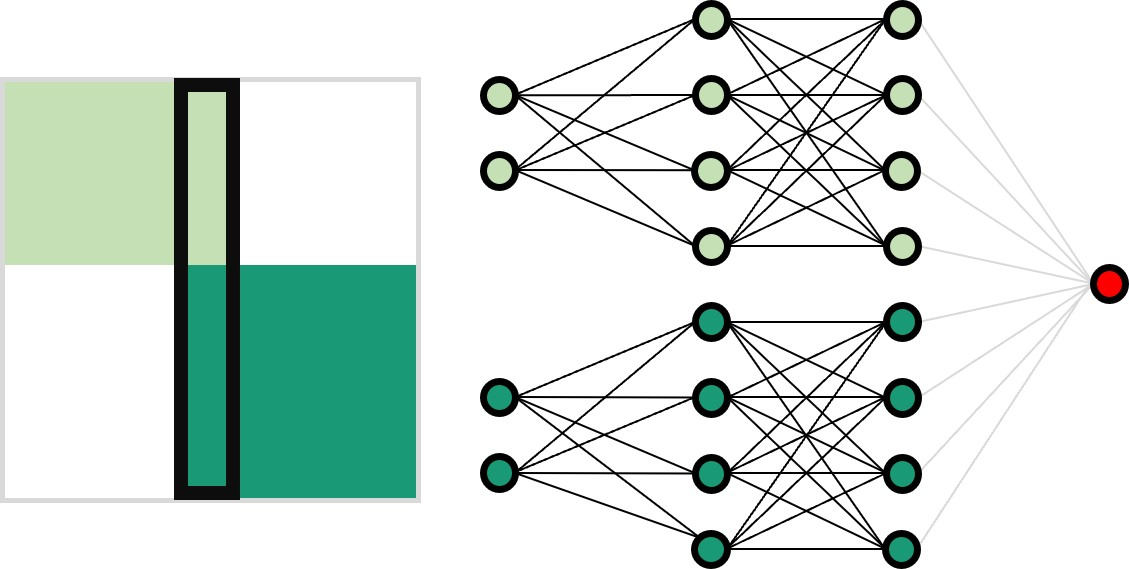

In [1]:
# Architecture of the GapNet
from IPython.display import Image
Image("./assets/Gapnet.jpg", width = 500) # change the path accordingly

The figure shows a schematic representation of the dataset (on the left) and the GapNet approach (on the right) where the training takes place in two stages, where the connectors in black are trained in the first stage and the connectors in gray are trained in the second one.

## Initialization

FIrst of all we load the main gapnet functions

In [2]:
from src import gapnet as gapnet

## Loading the dataset

We provide an example dataset adapted from the the simulated dataset [Madelon](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html?highlight=madelon). We provide two files: one including the inputs "X.npy" and one with the targets "y.npy".

The dataset consists of 1000 subjects of which only 100 have all 40 features. 

In [3]:
# load dataset and fill in missing values
from numpy import load

X = load('data/X.npy') 
y = load('data/Y.npy')

print("Number of features {}".format(X.shape[1]))
print("Number of subjects {}".format(X.shape[0]))

print("\nA small example extracted from the data:")
print( X[:5,23:28] ) 

Number of features 40
Number of subjects 1000

A small example extracted from the data:
[[         nan          nan  -1.62796269  -1.45050465   4.64826445]
 [         nan          nan  -2.21454432   6.39601004 -12.75771876]
 [         nan          nan   3.93988712  14.1241684    7.49902687]
 [         nan          nan   6.67470577  16.73326584  10.69169783]
 [         nan          nan  -4.98977314 -11.99376432   0.33999874]]


## Isolating the complete dataset

In [4]:
# The dataset with complete data
from numpy import isnan

X_overlap = X[~isnan(X).any(axis=1)]
y_overlap = y[~isnan(X).any(axis=1)]

print("The overlapping dataset includes {} subjects".format(X_overlap.shape[0]))

print("\nA small example extracted from the data:")
print( X_overlap[:5,23:28] ) 

The overlapping dataset includes 100 subjects

A small example extracted from the data:
[[ -1.11754154   1.0595167    0.64874652  -8.73842137   1.41250753]
 [  5.55678632   0.52259214  -1.64442068  12.21443722   5.7349601 ]
 [  2.78229744   1.38704174  -1.15030795   2.57076227   4.79713086]
 [  2.13645326  -0.62529765  -0.86125848   0.21899924   1.13525634]
 [ -1.16616648   0.15157106   2.66306085 -13.6112331   -2.87405407]]


## Generate the GapNet architecture


Now, it is possible to build and train the gapnet. 

It requires first of all to define an object that will include all gapnet elements, and is defined as      
*gapnet_object = gapnet.generate_gapnet_model()*

Afterwards, the build_model function is required to introduce the gapnet neural network architecture.     
*gapnet_object.build_model()*


At this point, the gapnet is ready to be trained over the two stages, using the functions train_first_stage and train_second_stage, that take as inputs the training and validation sets.   
*gapnet_model.train_first_stage(X_train, y_train, X_val, y_val)*                
*gapnet_model.train_second_stage(X_train, y_train, X_val, y_val)*

In [5]:
gapnet_model = gapnet.generate_gapnet_model(cluster_sizes = [25,15], n_feature = X.shape[1],n_classes = 2)
gapnet_model.build_model(show_summary=True, n_dense = 5)

Generating the 1 neural network model ... 
 
Generating the 2 neural network model ... 
 
Generating the final gapnet model ... 
 
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 25)]         0           []                               
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0           []                               
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 50)           1300        ['input_3[0][0]']                
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 30)           480      

## Train the GapNet model

In this example, we train the gapnet num_trials times with random splitting of training and validation data. 

In [6]:
num_trials = 5
for i in range(num_trials):
    i = i + 1
    gapnet_model.build_model(n_dense = 2)
    print("\n\nTraining process of trial #{} is starting...".format(i))
    X_train_with_missing_values, Y_train_with_missing_values, X_train, Y_train, X_val, Y_val = gapnet.preprocess_with_missing_data(X,y)
    gapnet_model.train_first_stage(X_train_with_missing_values, Y_train_with_missing_values, X_val, Y_val)
    gapnet_model.train_second_stage(X_train, Y_train, X_val, Y_val)

Generating the 1 neural network model ... 
 
Generating the 2 neural network model ... 
 
Generating the final gapnet model ... 
 
Training process of trial #1 is starting...
Training process of first stage is done.
Training process of second stage is done.
Generating the 1 neural network model ... 
 
Generating the 2 neural network model ... 
 
Generating the final gapnet model ... 
 
Training process of trial #2 is starting...
Training process of first stage is done.
Training process of second stage is done.
Generating the 1 neural network model ... 
 
Generating the 2 neural network model ... 
 
Generating the final gapnet model ... 
 
Training process of trial #3 is starting...
Training process of first stage is done.
Training process of second stage is done.
Generating the 1 neural network model ... 
 
Generating the 2 neural network model ... 
 
Generating the final gapnet model ... 
 
Training process of trial #4 is starting...
Training process of first stage is done.
Training p

At the end of the training process, we can evaluate the performance of the gapnet using the *present_results* function.

In [7]:
gapnet.present_results(gapnet_model)

Results :
best_epochs [157, 231, 141, 550, 137]
train_accuracy 0.922+/-0.032 : [0.95  0.9   0.875 0.962 0.925]
val_accuracy 0.890+/-0.037 : [0.9  0.9  0.85 0.95 0.85]
val_auc 0.937+/-0.041 : [0.879 0.919 0.96  1.    0.929]
val_sens 0.807+/-0.055 : [0.818 0.818 0.75  0.9   0.75 ]
val_spec 1.000+/-0.000 : [1. 1. 1. 1. 1.]
val_prec 1.000+/-0.000 : [1. 1. 1. 1. 1.]


## Plot the results

After training the gapnet, it is possible to show the results by plotting the ROC curve, the confusion matrix, the loss, precision and recall functions along the training.

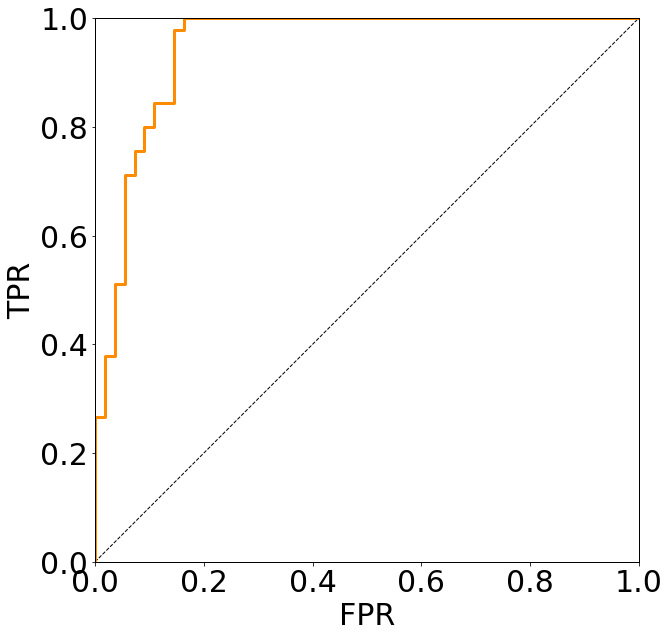

In [8]:
#plot roc
gapnet.plot_roc_avg("gapnet", gapnet_model.val_y_labels, gapnet_model.val_y_preds, 1, linestyle='solid', color='darkorange')

Legitimate Transactions Detected (True Negatives):  44
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  45
Total Fraudulent Transactions:  45


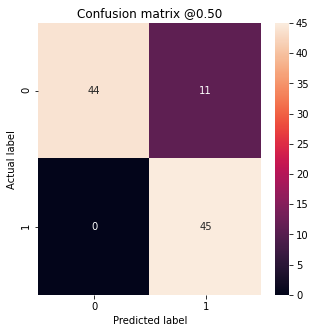

In [9]:
##plot confusion matrix
gapnet.plot_cm(gapnet_model.val_y_labels, gapnet_model.val_y_preds, 0.5)

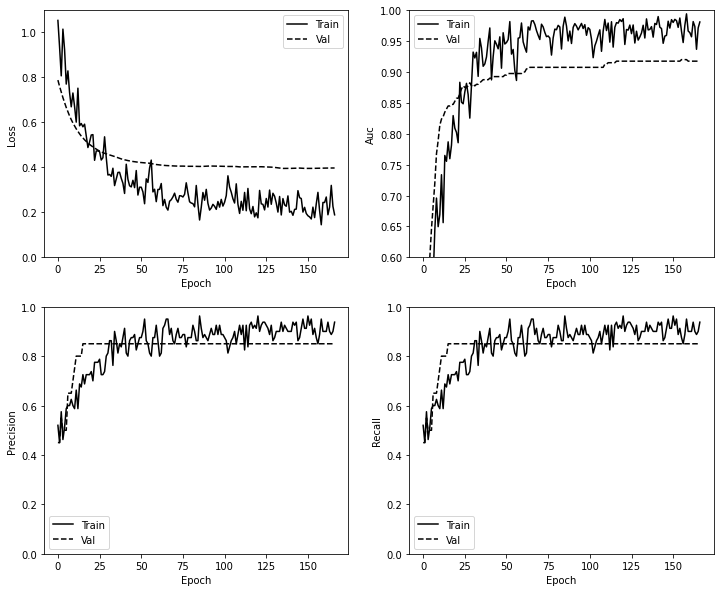

In [10]:
#plot training progress
gapnet.plot_metrics(gapnet_model.history['gapnet'])

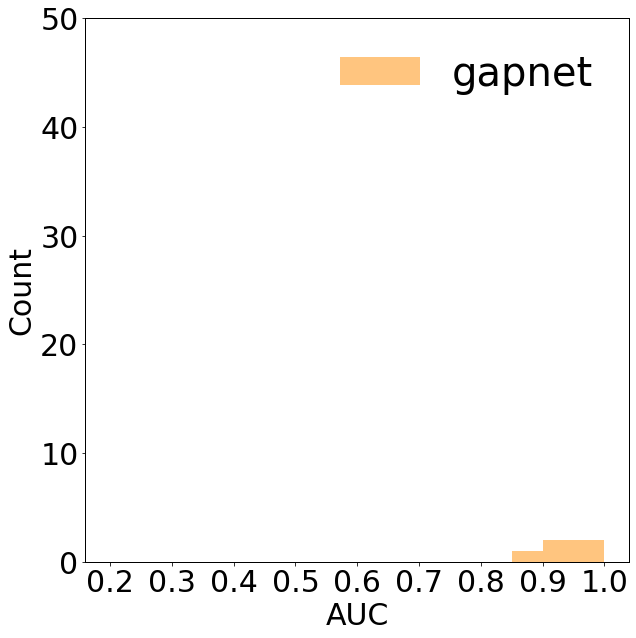

In [11]:
#plot hist
gapnet.plot_hist(gapnet_model.val_aucs, 'gapnet', color='darkorange', alpha=0.5)